In [30]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec

from sklearn.mixture import GaussianMixture

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder

SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

In [3]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016'

In [52]:
sorted_trials, _, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [56]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)])
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]

In [57]:
sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

sorted neural data shape: (265, 514, 30)


In [5]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [76]:
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

In [45]:
thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (265, 384, 30)


In [77]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/best_bic_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = loaded_gmm.predict(spike_features)
spike_probs = loaded_gmm.predict_proba(spike_features)

clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=True
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (265, 465, 30)


In [7]:
def plot_localization_features(
    data, 
    labels, 
    labels_display, 
    np1_channel_map,
    channels=[], 
    local=False,
    n_spikes=5_000, 
    figure_size=(8,16), 
    title='', 
):
    '''
    '''
    fig, axes = plt.subplots(1, 2, figsize=figure_size) 
    colors = [k for k,v in pltc.cnames.items()]
    random.shuffle(colors)
    for idx in labels_display:
        c = int(idx)
        if idx >= len(colors):
            c = c // 6  # only 148 colors available for plotting
            
        sub_data = data[labels == idx]
        x, z, maxptp = sub_data.T
        
        if len(sub_data) <= 2:
            continue
            
        if local:
            axes[0].scatter(x, z, s=.5, alpha=0.2, c=maxptp)
            axes[1].scatter(maxptp, z, s=.5, alpha=0.2, c=maxptp)
        else:
            axes[0].scatter(x[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            axes[1].scatter(maxptp[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            
        if local:
            axes[0].set_xlim(x.min()-25, x.max()+25)
            axes[0].set_ylim(z.min()-25, z.max()+25)
            axes[1].set_xlim(0, maxptp.max()+25)
            axes[1].set_ylim(z.min()-25, z.max()+25)
        else:    
            axes[0].set_xlim(-100, 175)
            axes[0].set_ylim(-80, 4000)
            axes[1].set_xlim(0, 60)
            axes[1].set_ylim(-80, 4000)
        
    if len(channels) > 0: 
        for channel in channels:
            axes[0].plot(np1_channel_map[int(channel), 0], 
                         np1_channel_map[int(channel), 1], 
                         markersize=3, c='orange', marker="s")
                
    axes[0].set_xlabel('x (um)')
    axes[0].set_ylabel('z (um)')
    axes[0].set_title(f'{title}')
    axes[1].set_xlabel('max ptp (amp)')
    axes[1].set_ylabel('z (um)')
    axes[1].set_title('')

    for ax in ['top','bottom','left','right']:
        axes[0].spines[ax].set_linewidth(1.5)
        axes[1].spines[ax].set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

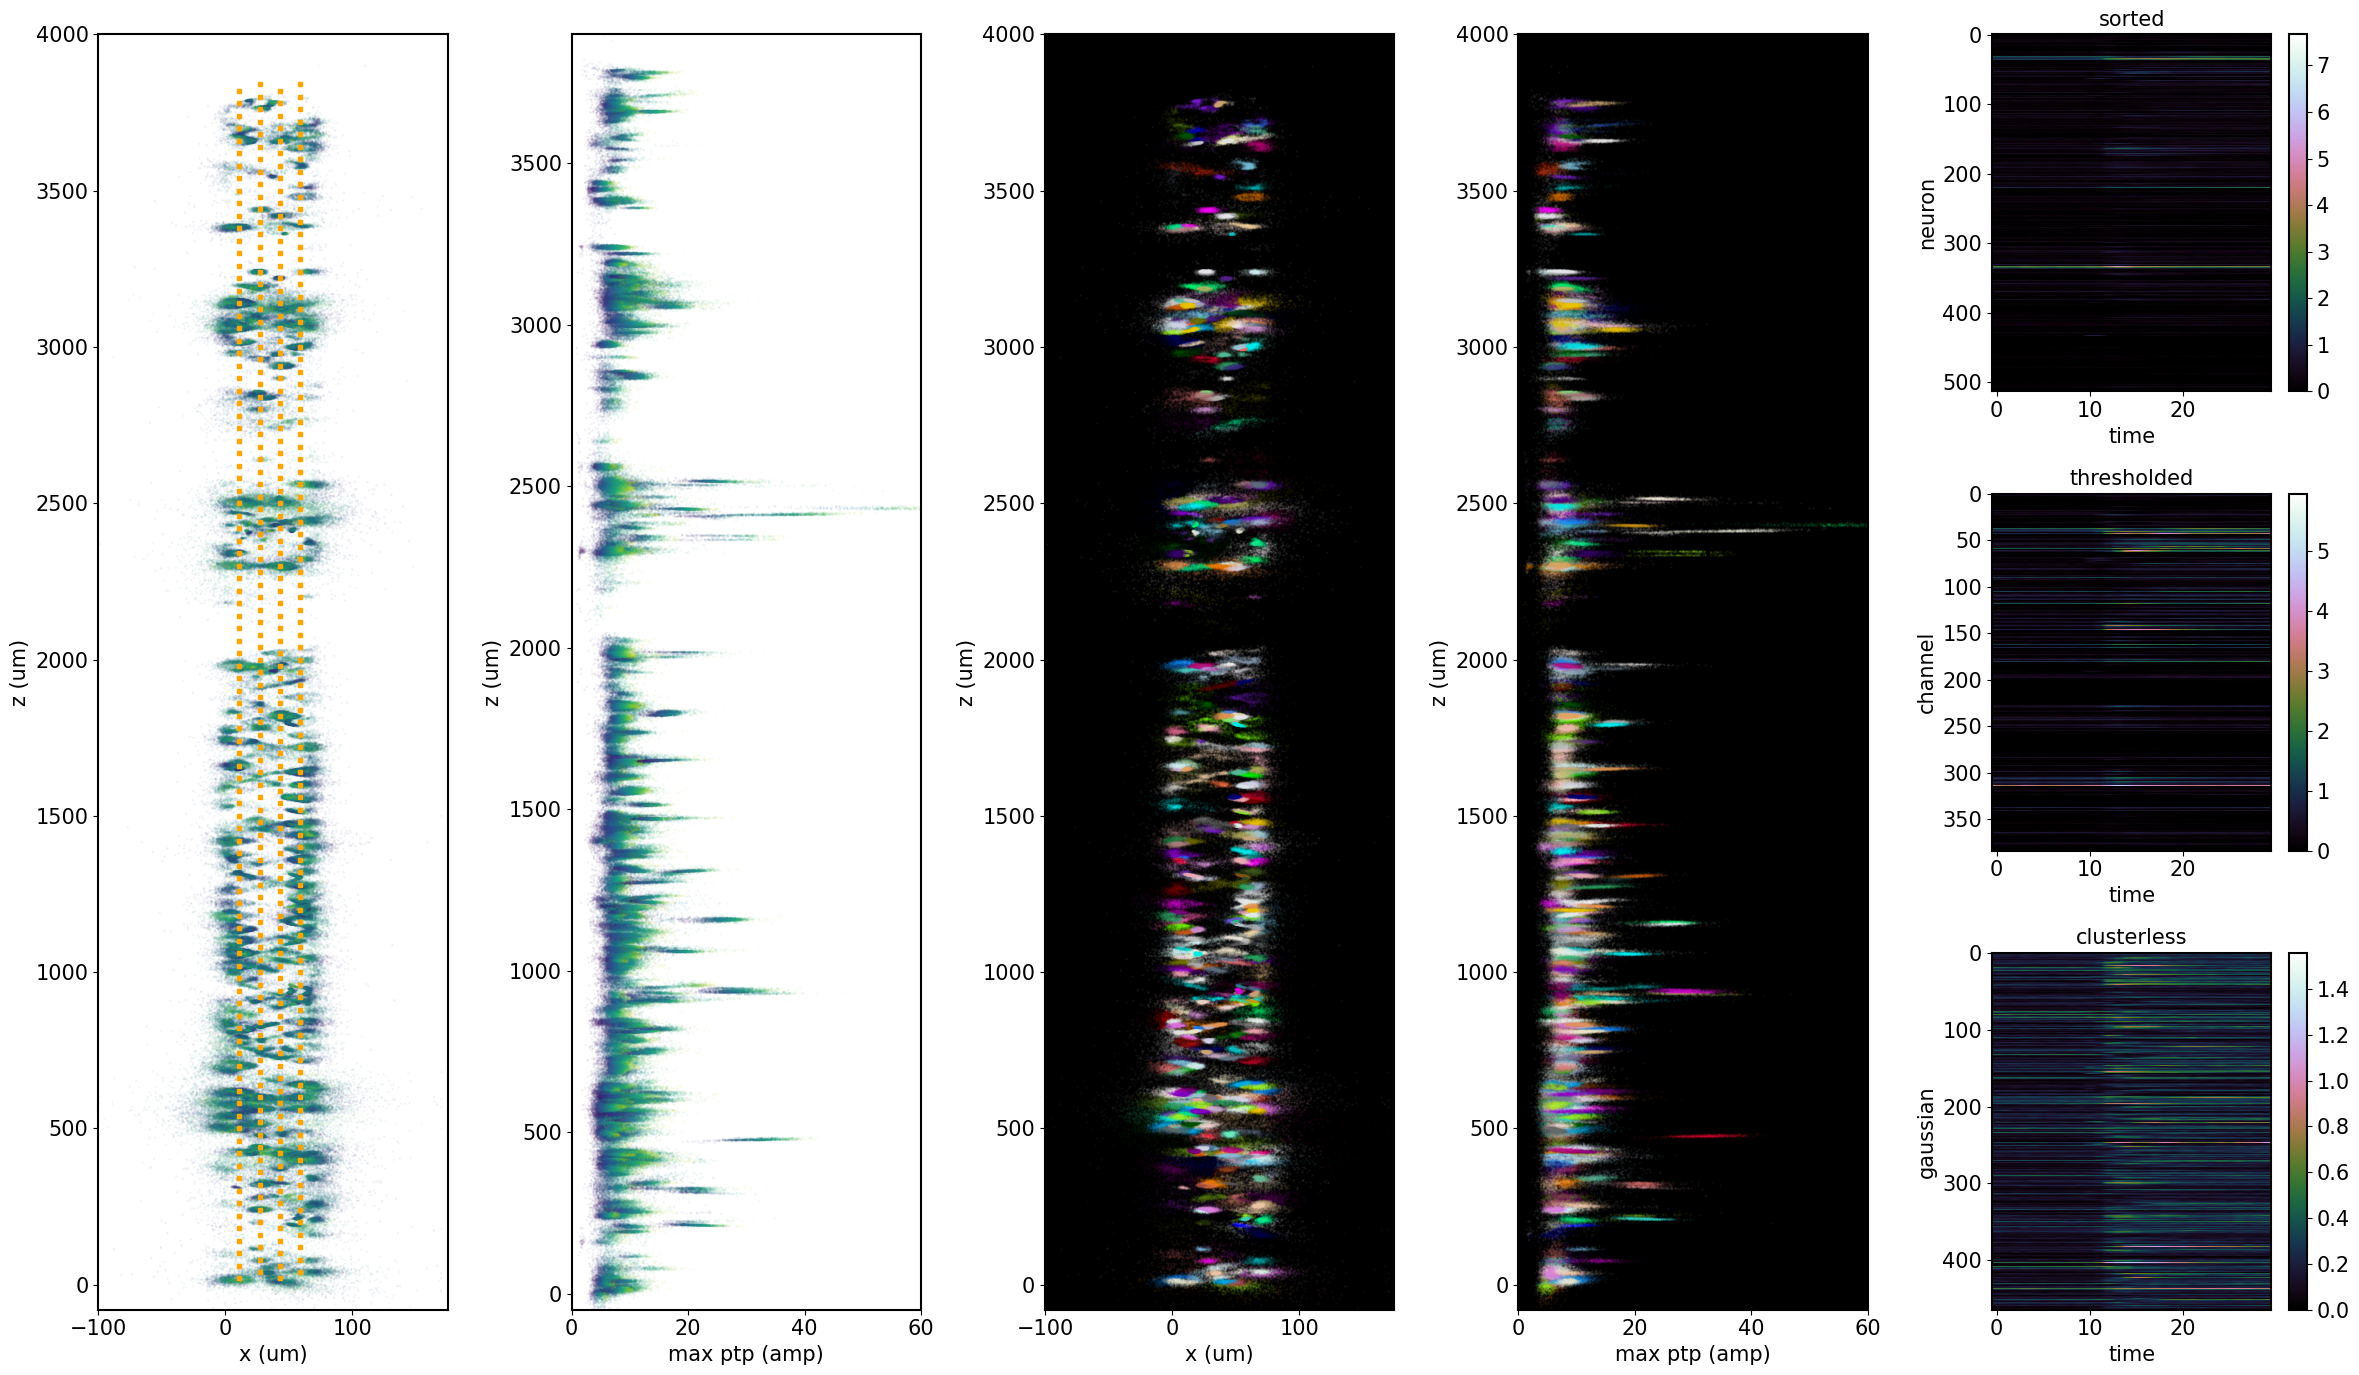

In [119]:
fig = plt.figure(figsize=(24,14))

gs = GridSpec(3, 5) 
colors = [k for k,v in pltc.cnames.items()]
random.shuffle(colors)

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1]) 
ax3 = fig.add_subplot(gs[:,2]) 
ax4 = fig.add_subplot(gs[:,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[1,4])
ax7 = fig.add_subplot(gs[2,4])

n_spikes = 1_000
channels = np.arange(384)
for idx in np.unique(spike_labels):
    c = int(idx)
    if idx >= len(colors):
        c = c // 6
        
    sub_data = spike_features[spike_labels == idx]
    x, z, maxptp = sub_data.T
    
    ax1.scatter(x[:n_spikes], z[:n_spikes], s=.5, alpha=0.05, c=maxptp[:n_spikes])
    ax2.scatter(maxptp[:n_spikes], z[:n_spikes], s=.5, alpha=0.05, c=maxptp[:n_spikes])
    ax3.scatter(x[:n_spikes], z[:n_spikes], s=.5, alpha=0.05, c=colors[c])
    ax4.scatter(maxptp[:n_spikes], z[:n_spikes], s=.5, alpha=0.05, c=colors[c])
    
if len(channels) > 0: 
    for channel in channels:
        ax1.plot(np1_channel_map[int(channel), 0], np1_channel_map[int(channel), 1], 
                     markersize=2.25, c='orange', marker="s")
        # ax3.plot(np1_channel_map[int(channel), 0], np1_channel_map[int(channel), 1], 
        #              markersize=2.25, c='orange', marker="s")

p5 = ax5.imshow(sorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
ax5.set_title('sorted')
ax5.set_xlabel('time') # change to seconds
ax5.set_ylabel('neuron')
plt.colorbar(p5, ax=ax5);  # make color bars all same colorscale

        
p6 = ax6.imshow(thresholded_neural_data.mean(0), aspect='auto', cmap='cubehelix')
ax6.set_title('thresholded')
ax6.set_xlabel('time') # change to seconds
ax6.set_ylabel('channel')
plt.colorbar(p6, ax=ax6);  # make color bars all same colorscale

p7 = ax7.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
ax7.set_title('clusterless')
ax7.set_xlabel('time') # change to seconds
ax7.set_ylabel('gaussian')
plt.colorbar(p7, ax=ax7);  # make color bars all same colorscale
    
ax1.set_xlim(-100, 175)
ax1.set_ylim(-80, 4000)
ax1.set_facecolor('white')
# plt.colorbar(ax=ax1, location='left')
ax2.set_xlim(0, 60)
ax2.set_ylim(-50, 3900)
ax2.set_facecolor('white')
ax3.set_xlim(-100, 175)
ax3.set_ylim(-80, 4000)
ax3.set_facecolor('black')
ax4.set_xlim(0, 60)
ax4.set_ylim(-80, 4000)
ax4.set_facecolor('black')
ax1.set_xlabel('x (um)')
ax1.set_ylabel('z (um)')
ax2.set_xlabel('max ptp (amp)')
ax2.set_ylabel('z (um)')
ax3.set_xlabel('x (um)')
ax3.set_ylabel('z (um)')
ax4.set_xlabel('max ptp (amp)')
ax4.set_ylabel('z (um)')

plt.tight_layout()
plt.savefig('cosyne_fig_1.png', dpi=1000)

In [82]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, _, wheel_speed, _, _, _ = preprocess.preprocess_dynamic_behaviors(behave_dict)

In [84]:
windowed_clusterless_neural_data, half_window_size, n_windows = decoder.sliding_window(
    clusterless_neural_data, 
    n_trials,
    window_size = 7
)


In [85]:
windowed_wheel_speed = wheel_speed[:,half_window_size:n_windows].reshape(-1,1)
windowed_motion_energy = motion_energy[:,half_window_size:n_windows].reshape(-1,1)

In [95]:
cv_r2s, cv_rmses, _, obs_motion_energy, pred_motion_energy = decoder.cv_decode_dynamic(
    windowed_clusterless_neural_data,
    windowed_motion_energy,
    n_trials,
    'motion energy'
)

motion energy fold 1 test r2: 0.465 rmse: 4.242
motion energy fold 2 test r2: 0.494 rmse: 3.954
motion energy fold 3 test r2: 0.537 rmse: 3.795
motion energy fold 4 test r2: 0.534 rmse: 3.983
motion energy fold 5 test r2: 0.509 rmse: 4.180
motion energy mean of 5-fold cv r2: 0.508 rmse: 4.031
motion energy sd of 5-fold cv r2: 0.026 rmse: 0.162


In [96]:
cv_r2s, cv_rmses, _, obs_wheel_speed, pred_wheel_speed = decoder.cv_decode_dynamic(
    windowed_clusterless_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

wheel speed fold 1 test r2: 0.468 rmse: 1.015
wheel speed fold 2 test r2: 0.498 rmse: 0.822
wheel speed fold 3 test r2: 0.504 rmse: 0.698
wheel speed fold 4 test r2: 0.404 rmse: 0.769
wheel speed fold 5 test r2: 0.495 rmse: 0.799
wheel speed mean of 5-fold cv r2: 0.474 rmse: 0.821
wheel speed sd of 5-fold cv r2: 0.037 rmse: 0.106


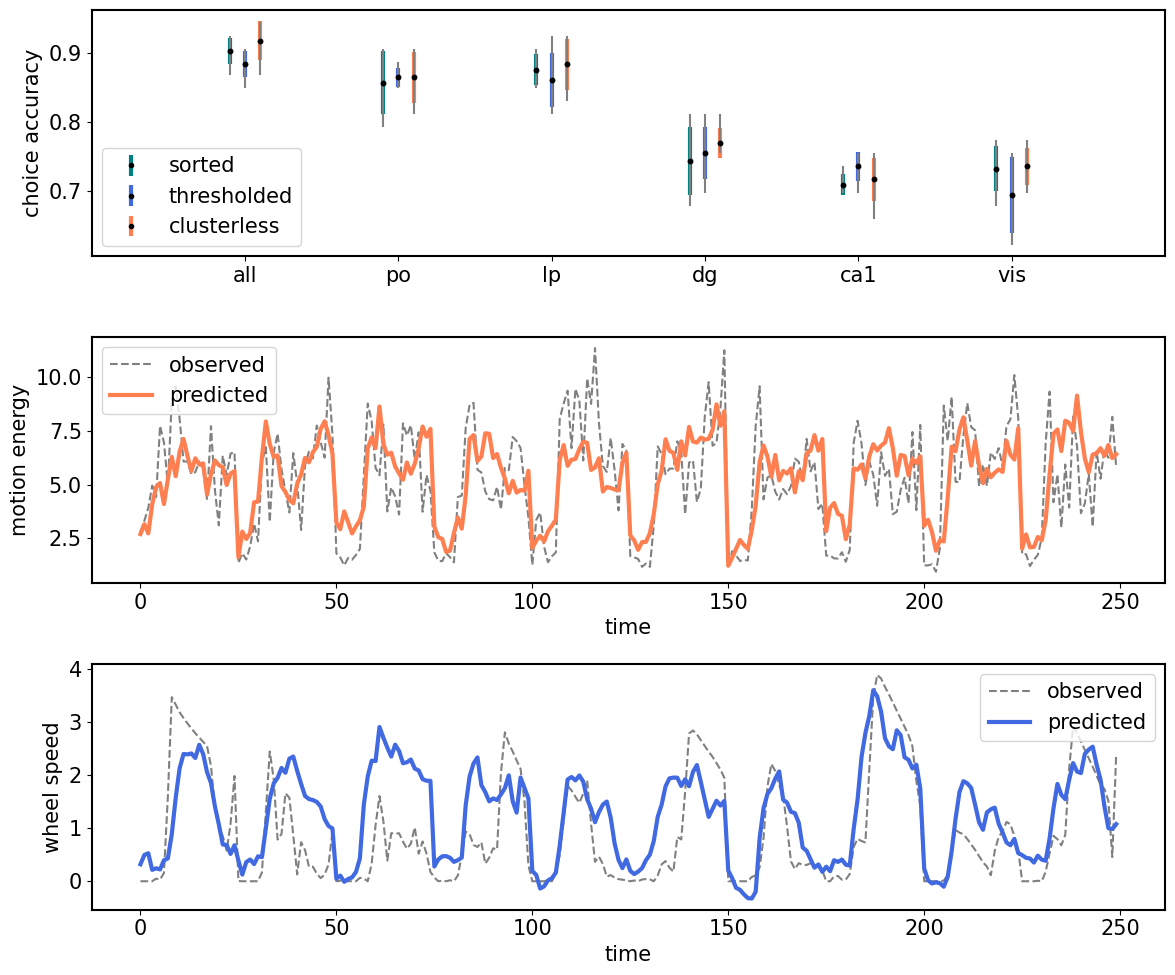

In [116]:
fig = plt.figure(figsize=(12,10))

gs = GridSpec(3, 1) 

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1]) 
ax3 = fig.add_subplot(gs[2]) 

rois = ['po', 'lp', 'dg', 'ca1', 'vis']

all_decode_results = np.load(
        f'{save_path}/static_behaviors/all_decode_results.npy', allow_pickle=True).item()
    
regional_decode_results = {
    rois[0]: np.load(
        f'{save_path}/static_behaviors/{rois[0]}_decode_results.npy', allow_pickle=True).item(),
    rois[1]: np.load(
        f'{save_path}/static_behaviors/{rois[1]}_decode_results.npy', allow_pickle=True).item(),     
    rois[2]: np.load(
        f'{save_path}/static_behaviors/{rois[2]}_decode_results.npy', allow_pickle=True).item(),
    rois[3]: np.load(
        f'{save_path}/static_behaviors/{rois[3]}_decode_results.npy', allow_pickle=True).item(),
    rois[4]: np.load(
        f'{save_path}/static_behaviors/{rois[4]}_decode_results.npy', allow_pickle=True).item()
}

idx = 0
behave_type = 'choice'
data_type = 'sorted'
sorted = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])
    
data_type = 'thresholded'
thresholded = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])
    
data_type = 'clusterless'
clusterless = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])

ticks = rois.copy(); ticks.insert(0, 'all')

mins, maxs, means, stds = sorted.min(1), sorted.max(1), sorted.mean(1), sorted.std(1)
ax1.errorbar(np.arange(len(ticks))*2-.2, means, stds, 
                 fmt='.k', ecolor='teal', lw=3, label='sorted')
ax1.errorbar(np.arange(len(ticks))*2-.2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=1.5)

mins, maxs, means, stds = thresholded.min(1), thresholded.max(1), thresholded.mean(1), thresholded.std(1)
ax1.errorbar(np.arange(len(ticks))*2, means, stds, 
             fmt='.k', ecolor='royalblue', lw=3, label='thresholded')
ax1.errorbar(np.arange(len(ticks))*2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=1.5)

mins, maxs, means, stds = clusterless.min(1), clusterless.max(1), clusterless.mean(1), clusterless.std(1)
ax1.errorbar(np.arange(len(ticks))*2+.2, means, stds, 
             fmt='.k', ecolor='coral', lw=3, label='clusterless')
ax1.errorbar(np.arange(len(ticks))*2+.2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=1.5)

ax1.legend(loc='lower left')
ax1.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
ax1.set_xlim(-2, len(ticks)*2)
ax1.set_ylabel('choice accuracy')

ax2.plot(np.hstack([obs_motion_energy[0][i] for i in range(0, 50, 5)]), 
         c='gray', linestyle='dashed', label='observed');
ax2.plot(np.hstack([pred_motion_energy[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), 
         c='coral', alpha=1., linewidth=3., label='predicted');
ax2.set_xlabel('time');
ax2.set_ylabel('motion energy');
ax2.legend();


ax3.plot(np.hstack([obs_wheel_speed[0][i] for i in range(10, 30, 2)]), 
         c='gray', linestyle='dashed', label='observed');
ax3.plot(np.hstack([pred_wheel_speed[0].reshape(-1, 25)[i] for i in range(10, 30, 2)]), 
         c='royalblue', alpha=1., linewidth=3., label='predicted');
ax3.set_xlabel('time');
ax3.set_ylabel('wheel speed');
ax3.legend();

plt.tight_layout()
plt.savefig('cosyne_fig_2.png', dpi=400)